---
title: Multi-Modal Tutorial ScDyO3
numbering:
  enumerator: 4.%s
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

### Guided Computation of Fused Multi-Modal Electron Microscopy

+++ {"part": "Code Walkthrough"} 
This tutorial describes how you can fuse your EELS/EDX maps with HAADF or similar elastic imaging modalities to improve chemical resolution. This is Tutorial 1 of 2 where we look at an atomic resolution HAADF and EDX dataset of DyScO$_3$. The multi-modal data fusion workflow relies on Python, and requires minimal user input with <10 tunable lines. Both here and in the Mathematical Overview section we outline best practices for these adjustments.  Within a few minutes, datasets such as the one in this tutorial can be transformed into resolution enhanced chemical maps. (Figure 4.1)
+++

:::{figure} ./figs/Figure_3_Output.png
:name: Raw vs Fused DyScO$_3$
:width: 700px
Comparison of raw input vs fused multi-modal DyScO$_3$ HAADF elastic and EDX inelastic images
:::

```{warning} Step 0: Experimental Requirements
To reconstruct using fused multi-modal electron microscopy you need to collect both elastic (e.g. HAADF) and inelastic (e.g. EELS / EDX) maps of your material. For the elastic signal, it is important that it provides Z-contrast of your elements. For the inelastic signal, you should have all chemistries in your sample mapped. Solving for under-determined chemical maps, or using difficult to interpret elastic signals are outside the scope of this tutorial. The collected chemical maps and HAADF must all have the same dimensionality, i.e. the same image size and number of pixels.  For this reason, we recommend using the HAADF signal that is simultaneously collected when taking an EDX/EELS scan
```

```{admonition} Step 1: Python Imports
First, we import standard python packages alongside our custom class of functions for data fusion called [fusion_utils](https://github.com/jtschwar/Multi-Modal-2D-Data-Fusion/blob/170fea3292da7e6390bfff7236610eb0c8077ff7/EDX/fusion_utils.py). The fusion_utils package contains 3 functions and a class of TV functions: save_data(), plot_convergence(), create_weighted_measurement_matrix(), and tvlib(). The save_data function saves the fused images into .tif files and all the parameters and matrix data into a .h5 file. Plot_convergence plots the convergence of the cost functions. Create_weighted_measurement_matrix is for generating the first part of our cost function that relates the elastic and inelastic modalities. Finally, the class of functions called tvlib performs the Fast Gradient Project (FGP) method of TV image denoising, which deblurs output images while preserving edges.
```

In [1]:
import data.fusion_utils as utils
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np

```{admonition} Step 2: Load your data
Load your inelastic and elastic data. Define the element names and their corresponding atomic weights. For the sake of this tutorial a generic .npz file is used, but for .dm3,.dm4,.emd, or another EM file format, just extract the 2D image data into numpy matrices. In Tutorial 2 this is shown by extracting from a .h5 file. Your elastic data should be stored in the HAADF variable, and your inelastic data (EDX/EELS) should be stored in the chemMap variable.
```
```{tip} Loading alternate file formats
If you are loading data from a .dm3, .dm4 or .emd file, we recommend you use HyperSpy.  The documentation for loading and saving data from those file types can be found [here](https://hyperspy.org/hyperspy-doc/v1.3/user_guide/io.html).
```

In [3]:
data = np.load('data/PTO_Trilayer_dataset.npz')
# Define element names and their atomic weights
elem_names=['Sc', 'Dy', 'O']
elem_weights=[21,66,8]
# Parse elastic HAADF data and inelastic chemical maps based on element index from line above
HAADF = data['HAADF']
xx = np.array([],dtype=np.float32)
for ee in elem_names:

	# Read Chemical Map for Element "ee"
	chemMap = data[ee]

    # Check if chemMap has the same dimensions as HAADF
	if chemMap.shape != HAADF.shape:
		raise ValueError(f"The dimensions of {ee} chemical map do not match HAADF dimensions.")
	
	# Set Noise Floor to Zero and Normalize Chemical Maps
	chemMap -= np.min(chemMap); chemMap /= np.max(chemMap)

	# Concatenate Chemical Map to Variable of Interest
	xx = np.concatenate([xx,chemMap.flatten()])

```{admonition} Step 3: Reshape your data
Run the following cell without changing anything.  This cell reshapes your data and relates the elastic to the inelastic modalities within a cost function, which is described in greater depth in the Mathematical Methods section.
```

```{danger} Caution!
Do not change the code below.

In [6]:
# Make Copy of Raw Measurements for Poisson Maximum Likelihood Term 
xx0 = xx.copy()

# Incoherent linear imaging for elastic scattering scales with atomic number Z raised to γ  ∈ [1.4, 2]
gamma = 1.6 

# Image Dimensions
(nx, ny) = chemMap.shape; nPix = nx * ny
nz = len(elem_names)

# C++ TV Min Regularizers
reg = utils.tvlib(nx,ny)

# Data Subtraction and Normalization 
HAADF -= np.min(HAADF); HAADF /= np.max(HAADF)
HAADF=HAADF.flatten()

# Create Summation Matrix
A = utils.create_weighted_measurement_matrix(nx,ny,nz,elem_weights,gamma,1)

```{admonition} Optional
:class: tip 
Plot your raw elastic/inelastic data
```

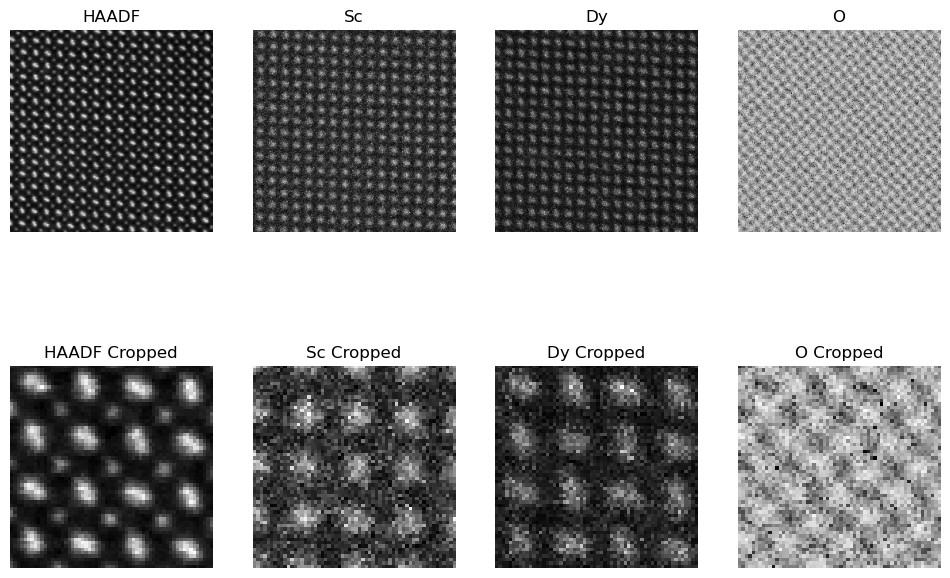

In [8]:
fig, ax = plt.subplots(2,len(elem_names)+1,figsize=(12,8))
ax = ax.flatten()
ax[0].imshow(HAADF.reshape(nx,ny),cmap='gray'); ax[0].set_title('HAADF'); ax[0].axis('off')
ax[1+len(elem_names)].imshow(HAADF.reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[1+len(elem_names)].set_title('HAADF Cropped'); ax[1+len(elem_names)].axis('off')

for ii in range(len(elem_names)):
    ax[ii+1].imshow(xx0[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny),cmap='gray'); ax[ii+1].set_title(elem_names[ii]); ax[ii+1].axis('off')
    ax[ii+2+len(elem_names)].imshow(xx0[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[ii+2+len(elem_names)].set_title(elem_names[ii]+' Cropped'); ax[ii+2+len(elem_names)].axis('off')
plt.show()

```{admonition} Step 4: Fine tune your weights for each of the three parts of the cost function 
The first weight, labeled as lambdaHAADF, is defined as the inverse of the number of elements to normalize each element's contribution. This prevents a single element from disproportionately influencing the solution.  The second weight, labeled as lambdaChem, is our data consistency term and we typically find to be ideal between 0.05 and 0.3 although the total range for this term is 0 to 1. The final weight is lambdaTV and it dictates how strong our Total Variation denoising is. In order to preserve fine features while removing noise, we find that a <0.2 lambdaTV value is ideal. nIter is the number of iterations the cost function will run for. although we typically see convergence within 10 iterations, we recommend using 30 iterations to make sure convergence is met long term. the variable bkg represents the background and we use this number to perform minor background subtraction to try and reduce noise; we recommend keeping this variable small. Finally, we give the user the option to turn the TV regularization off, and define a nIter_TV variable to define the number of iterations the FGP TV algorithm should run for.
```

In [11]:
# Convergence Parameters
lambdaHAADF = 1/nz # Do not modify this
lambdaChem = 0.08
lambdaTV = 0.15; #Typically between 0.001 and 1
nIter = 30 # Typically 10-15 will suffice
bkg = 2.4e-1

# FGP TV Parameters
regularize = True; nIter_TV = 3; 

```{admonition} Step 5: Run the Fused Multi-Modal algorithm
The code will typically finsh running in <10 seconds even when runnings for hundreds of iterations.  For most applications, the number of iterations will be <100 and the code should run in under 3 seconds.

```

```{danger} Caution!
Do not change the code below.
```

In [12]:
# xx represents the flattened 1D elastic maps we are trying to improve via the cost function
xx = xx0.copy()

# Auxiliary Functions for measuring the cost functions
lsqFun = lambda inData : 0.5 * np.linalg.norm(A.dot(inData**gamma) - HAADF) **2
poissonFun = lambda inData : np.sum(xx0 * np.log(inData + 1e-8) - inData)

# Main Loop

# Initialize the three cost functions components 
costHAADF = np.zeros(nIter,dtype=np.float32); costChem = np.zeros(nIter, dtype=np.float32); costTV = np.zeros(nIter, dtype=np.float32);

for kk in tqdm(range(nIter)):
	# Solve for the first two optimization functions $\Psi_1$ and $\Psi_2$
	xx -=  gamma * spdiags(xx**(gamma - 1), [0], nz*nx*ny, nz*nx*ny) * lambdaHAADF * A.transpose() * (A.dot(xx**gamma) - HAADF) + lambdaChem * (1 - xx0 / (xx + bkg))

	# Enforce positivity constraint
	xx[xx<0] = 0

	# FGP Regularization if turned on
	if regularize:
		for zz in range(nz):
			xx[zz*nPix:(zz+1)*nPix] = reg.fgp_tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny), lambdaTV, nIter_TV).flatten()

			# Measure TV Cost Function
			costTV[kk] += reg.tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny) )
			
	# Measure $\Psi_1$ and $\Psi_2$ Cost Functions
	costHAADF[kk] = lsqFun(xx); costChem[kk] = poissonFun(xx)

100%|███████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.52it/s]


```{admonition} Step 6: Assess Convergence
Assess convergence by confirming that all 3 cost functions asymptotically approach a low value as shown in the example plots below.   You should see all three curves start high and approach a plateau without any substantial changes. Sometimes the metric value may appear as a exponential decay and othertimes it may overshoot briefly superficially resembling the shape of a Lennard-Jones potential. Look out for incomplete convergence or severe oscillations. If you do not have convergence, the easiest solution is to run the reconstruction for more iterations or adjust the associated lambda value for that term.  For example, if the lambdaCHEM cost function does not show convergence, try change the lambdaCHEM value to something lower.  Repeat until all 3 cost functions show convergence.
```

:::{figure} ./figs/Figure_4_Convergence.png
:name: convergence
:width: 700px
Convergence of 3 subparts of the multi-modal cost function.  The top plot represents the first term that is dictated by $\lambda_{\text{HAADF}}$.  The middle plot represents the second term that is dictated by $\lambda_{\text{Chem}}$. The bottom plot represents the third TV term that is dictated by $\lambda_{\text{TV}}$. 
:::

```{admonition} Be careful with $\lambda_{\text{TV}}$!
:class: attention
You may see convergence with an over or under weighted TV term.  Under weighting the TV term results in noisy reconstructions, while over weighting results in blurring and loss of features in the image.  Below is an example of the output images from under, over, and just right TV weights. Err on the side of under weighting the TV term  because noise is familiar to the data, but when oversmoothing, the added artifacts are unphysical and can lead to faulty interpretations.
```

:::{figure} ./figs/Figure_5_TV.png
:name: TV_weights
:width: 700px
Comparison of TV weighting across different chemistries and HAADF. Too low of a TV results in noise and artifacts across images.  Proper TV preserves fine features like the dumbell shape of the Dy particles, while reducing noise.  High TV oversmoothes the image resulting in loss of important features for analysis.
:::

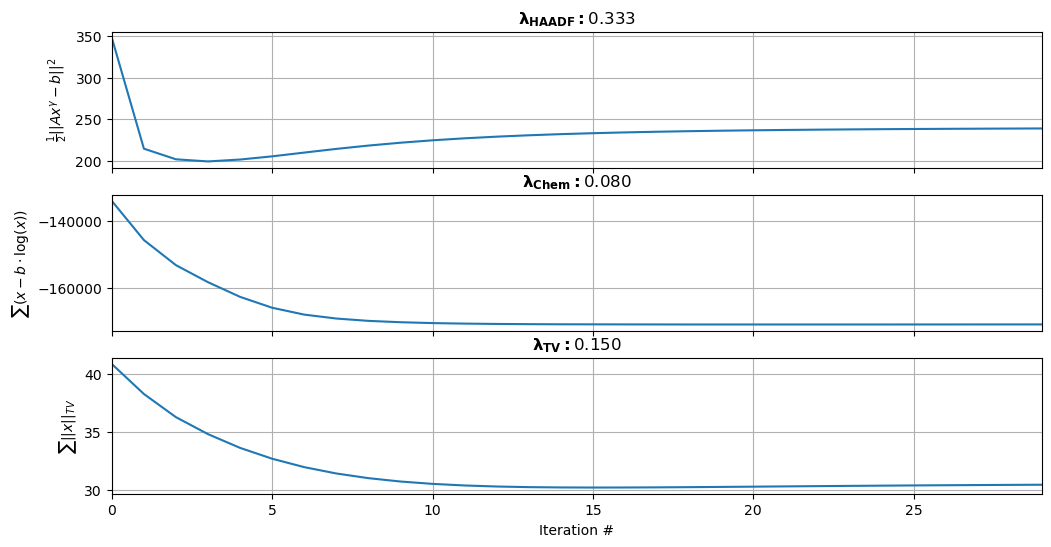

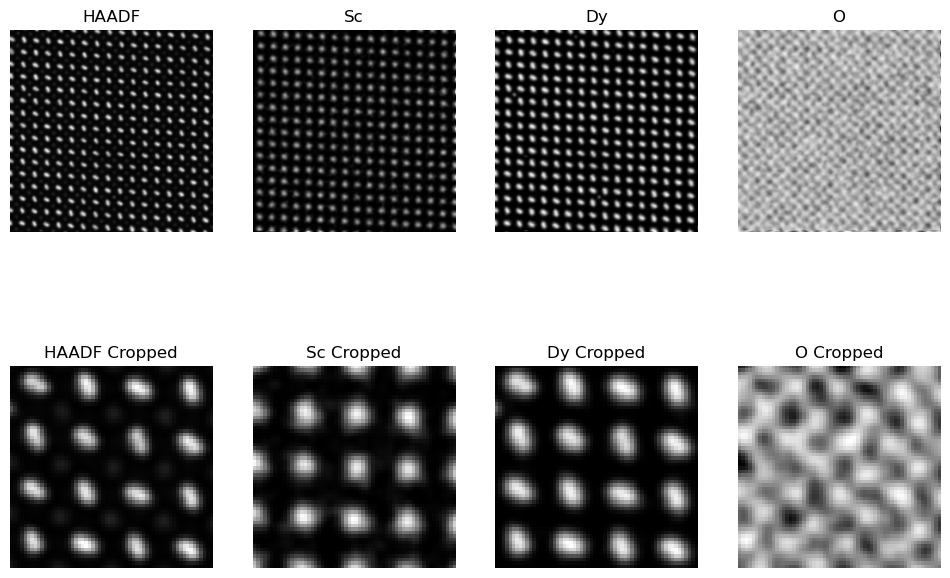

In [13]:
# Display Cost Functions and Descent Parameters
utils.plot_convergence(costHAADF, lambdaHAADF, costChem, lambdaChem, costTV, lambdaTV)
# Show Reconstructed Signal
fig, ax = plt.subplots(2,len(elem_names)+1,figsize=(12,8))
ax = ax.flatten()
ax[0].imshow((A.dot(xx**gamma)).reshape(nx,ny),cmap='gray'); ax[0].set_title('HAADF'); ax[0].axis('off')
ax[1+len(elem_names)].imshow((A.dot(xx**gamma)).reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[1+len(elem_names)].set_title('HAADF Cropped'); ax[1+len(elem_names)].axis('off')

for ii in range(len(elem_names)):
    ax[ii+1].imshow(xx[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny),cmap='gray'); ax[ii+1].set_title(elem_names[ii]); ax[ii+1].axis('off')
    ax[ii+2+len(elem_names)].imshow(xx[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx,ny)[70:130,25:85],cmap='gray'); ax[ii+2+len(elem_names)].set_title(elem_names[ii]+' Cropped'); ax[ii+2+len(elem_names)].axis('off')
plt.show()

```{admonition} Try it yourself!
Try changing lambda parameters to see how convergence is effected
```

:::{figure} #app:tutorialone
:name: lambda_widget_2
Try it yourself! Lambda parameter tuning
:::

```{admonition} Step 7: Save your data
Define the folder you would like to save to. The output images and data will be saved to .tif and .h5 file formats
```

In [15]:
save_folder_name='test'
utils.save_data(save_folder_name, xx0, xx, HAADF, A.dot(xx**gamma), elem_names, nx, ny, costHAADF, costChem, costTV, lambdaHAADF, lambdaChem, lambdaTV, gamma)

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'test/Fused_Reconstruction.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)